In [1]:
import pandas as pd
from pathlib import Path

In [16]:
chunks_path = Path('/Users/stefan/Downloads/processed_tweets_chunks/')

In [27]:
%time df = pd.concat(pd.read_csv(file) for file in chunks_path.iterdir())

/Users/stefan/.virtualenvs/swear/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


CPU times: user 1min 33s, sys: 14.6 s, total: 1min 48s
Wall time: 1min 50s


In [272]:
f'{len(df):,}'

'933,847'

In [237]:
bins = [-1, 0, 25, 100, 250, 1_000, 3_000, 8_000, 25_000, 200_000, 1_000_000, max(df.engagment)]
pd.DataFrame(
    [(a, b, ((df.engagment > a) & (df.engagment <= b)).sum()) for a, b in zip(bins, bins[1:])],
    columns=['a', 'b', '#tweets'],
    dtype=int
).style.format('{:,}'.format)

,a,b,#tweets
0,-1,0,"300,000"
1,0,25,"280,918"
2,25,100,"19,082"
3,100,250,"90,351"
4,250,"1,000","69,115"
5,"1,000","3,000","47,490"
6,"3,000","8,000","42,992"
7,"8,000","25,000","38,813"
8,"25,000","200,000","34,370"
9,"200,000","1,000,000","10,014"


In [135]:
%%time 
df = pd.concat([
    df[df.engagment == 0].sample(300_000),
    df[(df.engagment > 0) & (df.engagment <= 100)].sample(300_000),
    df[df.engagment > 100],
])

CPU times: user 3.54 s, sys: 560 ms, total: 4.1 s
Wall time: 4.1 s


In [142]:
f'{len(df):,}'

'933,847'

---

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
import numpy as np

In [138]:
import seaborn as sns

In [140]:
sns.set()

In [144]:
df['per_engagement'] = df.engagment / df.n_user_followers

In [168]:
df['engagement_bin'] = np.digitize(df.engagment, bins, right=True)

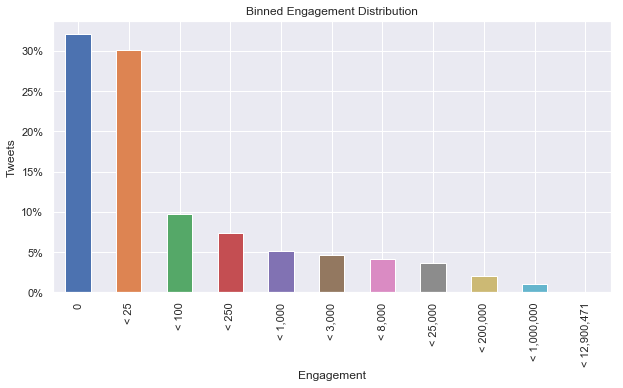

In [238]:
plt.figure(figsize=(10, 5))

(df.engagement_bin.value_counts() / len(df)).plot(kind='bar')

plt.xlabel('Engagement')
plt.ylabel('Tweets')

ax = plt.gca()
ax.set_xticklabels(f'< {int(b):,}' if b > 0 else 0 for b in bins[1:])
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])

plt.title('Binned Engagement Distribution')
plt.show()

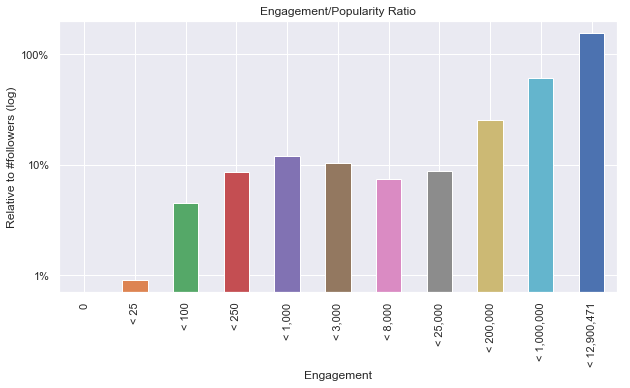

In [239]:
plt.figure(figsize=(10, 5))

df.groupby('engagement_bin').per_engagement.mean().plot(kind='bar')

plt.xlabel('Engagement')
plt.ylabel('Relative to #followers (log)')

plt.yscale('log')

ax = plt.gca()
# ax.set_yticks([0, .1, .2, .3, .4, .5, .75, 1, 1.5])

ax.get_yaxis().get_major_formatter().labelOnlyBase = False

ax.set_xticklabels(f'< {int(b):,}' if b > 0 else 0 for b in bins[1:])
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])

plt.title('Engagement/Popularity Ratio')
plt.show()

In [214]:
df['engagement_score'] = np.log(df.per_engagement * 100 + 1)

In [230]:
pd.options.display.float_format = None
pd.set_option('max_colwidth', 240)

In [233]:
df.columns

Index(['censored_presence', 'curse', 'date', 'day_of_week', 'eggplant',
       'engagment', 'fuck', 'hour_of_day', 'is_outlier', 'is_reply',
       'is_user_bot', 'is_valid', 'mfinger', 'n_emojis', 'n_favorites',
       'n_hashtags', 'n_links', 'n_mentions', 'n_retweets', 'n_user_followers',
       'n_user_following', 'n_user_posts', 'numMentions', 'processed_text',
       'swear_count', 'swear_present', 'text', 'text_len', 'text_polarity',
       'text_standardized', 'text_subjectivity', 'text_token',
       'text_token_rem_stop', 'user_id', 'vader_comp', 'vader_neg',
       'vader_neu', 'vader_pos', 'per_engagement', 'engagement_bin',
       'engagement_score'],
      dtype='object')

In [271]:
df[df.swear_present & (df.engagement_score > 10)][['text', 'n_user_followers', 'n_favorites', 'n_retweets', 'per_engagement', 'engagement_score']].sort_values(by='engagement_score', ascending=False)

,text,n_user_followers,n_favorites,n_retweets,per_engagement,engagement_score
1278466,Whoever didn’t power up was a bitch https://t.co/i3Gnzx9VTZ,2054.0,648853.0,1111400.0,856.987829,11.358606
568114,oh that nigga stupid stupid https://t.co/vsXo8A3RAt,695.0,141195.0,154365.0,425.266187,10.657909


In [216]:
df.engagement_score.describe()

count             933,847.0
mean    0.41756397092312697
std      0.8264501905012747
min                     0.0
25%                     0.0
50%     0.04321841939488681
75%     0.42837359890503446
max      11.457080563598575
Name: engagement_score, dtype: float64

## holidays

In [274]:
import holidays

In [276]:
from datetime import date

In [305]:
chosen_holidays = [holidays.UnitedStates(), holidays.EuropeanCentralBank()]

In [306]:
def is_holiday(d) -> bool:
    """ input can be str, date object, etc (anything accepted by the holidays package) """
    if 
    return any(d in h for h in chosen_holidays)

In [317]:
%%time 
have_date = ~pd.isna(df.date)
df.loc[have_date, 'on_holiday'] = df[have_date].date.map(is_holiday)

CPU times: user 28.4 s, sys: 268 ms, total: 28.7 s
Wall time: 28.8 s


In [318]:
f'{df.on_holiday.mean():.2%}'

'3.21%'

## LIWC

In [320]:
import liwc
from collections import Counter

[LIWC dictionary download](https://raw.githubusercontent.com/BenjaminDHorne/The-NELA-Toolkit/153e740dd05643ebabd21784065c034eadb4327b/credibility_toolkit/features/resources/LIWC2007_English100131.dic)

In [462]:
liwc_parse, liwc_categories = liwc.load_token_parser('/Users/stefan/Downloads/LIWC2007_English100131.dic')

[LIWC dimensions and categories, with examples](http://lit.eecs.umich.edu/~geoliwc/LIWC_Dictionary.htm)

In [378]:
len(liwc_categories)

64

In [364]:
def liwc_features(tokens: [str]) -> {str: int}:
    c = Counter(category for token in tokens for category in liwc_parse(token))
    return dict(c)

In [451]:
have_tokens = ~pd.isna(df.text_token)

In [491]:
# because they are stored as a string "['how', 'are', 'you']", not as a list of strings
# very unsafe!!
%time df.loc[have_tokens, 'text_token'] = df[have_tokens].text_token.map(eval)

CPU times: user 3.33 s, sys: 14.8 ms, total: 3.34 s
Wall time: 3.34 s


In [493]:
%%time
liwc_df = pd.DataFrame(df[have_tokens].text_token.map(liwc_features).tolist())\
    .fillna(0)\
    .astype(int)
liwc_df.rename({c: 'liwc_' + c for c in liwc_df}, axis='columns')

CPU times: user 6.46 s, sys: 236 ms, total: 6.7 s
Wall time: 6.7 s


In [496]:
%%time
# put them back in the df
for c in liwc_df:
    df.loc[have_tokens, c] = liwc_df[c].values

CPU times: user 10.5 s, sys: 9.72 s, total: 20.2 s
Wall time: 20.5 s


In [500]:
liwc_df.describe()

,liwc_achieve,liwc_adverb,liwc_affect,liwc_anger,liwc_anx,liwc_article,liwc_assent,liwc_auxverb,liwc_bio,liwc_body,...,liwc_social,liwc_space,liwc_swear,liwc_tentat,liwc_they,liwc_time,liwc_verb,liwc_we,liwc_work,liwc_you
count,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,...,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000
mean,0.266310,0.411115,0.888194,0.063773,0.025288,0.719364,0.079157,0.673260,0.213736,0.057878,...,1.016389,0.703910,0.014551,0.158529,0.043251,0.690074,1.247863,0.087894,0.220361,0.254800
std,0.573376,0.703050,1.078407,0.271554,0.165949,0.951684,0.295162,0.940194,0.511853,0.258335,...,1.281014,0.969322,0.127191,0.433829,0.233458,0.959607,1.369872,0.343541,0.549763,0.578016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
max,7.000000,8.000000,20.000000,5.000000,4.000000,8.000000,7.000000,10.000000,8.000000,5.000000,...,14.000000,11.000000,4.000000,6.000000,5.000000,9.000000,20.000000,7.000000,7.000000,14.000000


In [513]:
mask = have_tokens & ((df.swear_count + df.liwc_swear) > 0)

In [514]:
swear_diff = df[mask].swear_count - df[mask].liwc_swear

In [515]:
f'{len(swear_diff):,} valid tweets that have swears'

'2,933 valid tweets that have swears'

In [516]:
swear_diff.describe()

count    2933.000000
mean       -0.043982
std         0.606728
min        -3.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
dtype: float64

In [517]:
f'in {(swear_diff > 0).mean():.2%} of cases, our method discovered more swear words'

'in 14.56% of cases, our method discovered more swear words'

In [518]:
f'in {(swear_diff < 0).mean():.2%} of cases, liwc discovered more'

'in 18.58% of cases, liwc discovered more'

## Parts of speech

In [520]:
import nltk
from nltk.stem.porter import PorterStemmer

In [521]:
# nltk pos tagging dependencies
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stefan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[Description of POS shorthands](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

In [530]:
def count_pos(tokens: [str]) -> {str: int}:
    word_tags = nltk.pos_tag(tokens)
    return dict(Counter(tup[1] for tup in word_tags))

In [531]:
%%time
pos_df = pd.DataFrame(df[have_tokens].text_token.map(count_pos).tolist())\
    .fillna(0)\
    .astype(int)
pos_df.rename({c: 'pos_' + c for c in pos_df}, axis='columns')

CPU times: user 1min 36s, sys: 2.34 s, total: 1min 38s
Wall time: 1min 38s


In [532]:
%%time
# put them back in the df
for c in pos_df:
    df.loc[have_tokens, c] = pos_df[c].values

CPU times: user 23 s, sys: 21.5 s, total: 44.5 s
Wall time: 44.7 s


In [533]:
pos_df.describe()

,$,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
count,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,...,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000,186099.000000
mean,0.000021,0.000081,0.215874,0.059882,0.942617,0.012354,0.055030,1.137803,1.120398,0.029823,...,0.577295,0.232065,0.272559,0.166368,0.450674,0.240883,0.026427,0.064734,0.000811,0.057002
std,0.004636,0.008978,0.476756,0.257534,1.088592,0.114190,0.525615,1.195617,1.174787,0.180431,...,0.875785,0.524230,0.546016,0.435196,0.732272,0.503060,0.163520,0.260608,0.028474,0.245775
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,4.000000,20.000000,3.000000,20.000000,9.000000,10.000000,5.000000,...,12.000000,5.000000,7.000000,5.000000,13.000000,5.000000,3.000000,4.000000,1.000000,4.000000
